# Julia for Economists: Intro

**Written for the North American Econometric Society Summer Meeting, June 2016**

**Author**: Chase Coleman

Julia is a new computing language that centers on numerical computation and is built around just in time (JIT) compiling. It's features allow it to achieve near C-like speeds while maintaining the ability to write high level code.

**Pros**

* Fast
* High level language
* Well designed language
* Good community/package ecosystem

**Cons**

* Smaller community/package ecosystem than Python
* Stability (language is new and currently developing)
* Performance is not typically worse than other languages, but unlocking full potential sometimes requires some thought

This is a relatively short seminar, so you won't be able to pick up all of the ins and outs of julia. Our goal is help get julia installed, teach you some of the basic syntax, and to expose you to the ideas that make it a nice language.

## Syntax Introduction

I use a function which applies bisection to solve for the 0 of a function to highlight some syntax features.

This should feel familiar to people who have previously used matlab.

In [1]:
# *1                          *2       *3
function bisect(f, a, b, maxit=100, tol::Float64=1e-9)
    # Get value of function at both points
    fa, fb = f(a), f(b)

    # Make sure points have different signs
    if fa*fb > 0
        # *4
        error("The function f must have different signs at points a and b")
    end

    # Iterate over 1, 2, ..., maxit
    # *5      *6
    for it in 1:maxit
        # Find midpoint and evaluate function there 
        mid = (a + b)/2
        fmid = f(mid)

        # *7
        if abs(fmid) < tol            
            # *8
            return mid
        end

        if fa*fmid > 0
            fa, a = fmid, mid  
        else
            fb, b = fmid, mid
        end
    end
    
    error("maximum iterations exceeded")
end

bisect (generic function with 3 methods)

1. Define new functions with `function ... end`
2. Default arugments `(..., arg=default_value)`
3. Typed arguments `(..., arg::Type)`
4. Throwing error `error(MESSAGE)`
5. For loop `for X (in|=) SOMETHING ... end`
6. Create ranges `A:B` (not dense like Matlab)
7. If statement `if CONDITION BLOCK end`
8. Return statement `return STUFF`

In [2]:
# shorthand function syntax
f(x) = x^2-2

# longer syntax -- Equivalent
function f2(x)
    return x^2-2
end

f2 (generic function with 1 method)

In [3]:
println(bisect(f, 0, 4))
println(bisect(f2, 0, 4))

1.4142135623842478
1.4142135623842478


## Types

Everything in julia has a type. Many of you are probably familiar with the basic types:

* string
* float
* integer

This can be thought of as a `class` for those who are familiar with object oriented programming. This turns out to be an important feature of the language (for reasons we will soon talk about) and users are encouraged to define their own types.

We can determine the type of any variable in julia by using the `typeof` function.

In [4]:
println(typeof(1.0))
println(typeof(1))
println(typeof("Hello World"))
println(typeof(bisect))

Float64
Int64
ASCIIString
Function


Additionally, some types are described by "type parameters." This is just additional information about the type that allows the compiler to better optimize the code it generates. Type parameters are displayed in curly brackets `{` `}`

In [5]:
x = randn(10)  # 10 random draws from N(0, 1)
y = [1, 2, 3, 4]  # vector of 1, 2, 3, 4
z = reshape(y, 2, 2)  # reshape the vector into a 2x2 matrix

println(typeof(x))
println(typeof(y))
println(typeof(z))

Array{Float64,1}
Array{Int64,1}
Array{Int64,2}


There are two kinds of types:

* abstract types
* concrete types

You cannot actually create instances of an abstract type, but it serves as a grouping mechanism.

Consider as an example the types `Integer` and `Float`. These two are obviously related in the sense that they are numeric -- In julia there is an abstract type `Number` and both `Integer` and `Float` are sub-types of that abstract type.

In [6]:
Integer <: Number

true

In [7]:
Float64 <: Number

true

Syntax for defining our own types is as follows:

In [8]:
abstract StochasticProcess

"""
A Bernoulli process, X_t, is a sequence of 0s (failure) and
1s (successes) which represent the outcome of sequential
independent draws from the Bernoulli distribution

Success with probability p
"""
type BernoulliProcess <: StochasticProcess
    p::Float64
end

"""
This type represents a "standard" first order autoregressive process
described by

    y_{t+1} = ρ y_t + σ ɛ_{t+1}
"""
type AR1 <: StochasticProcess
    ρ::Float64  # you should put types on the fields of your types
    σ::Float64
end


In [9]:
?BernoulliProcess

search: BernoulliProcess



A Bernoulli process, X_t, is a sequence of 0s (failure) and 1s (successes) which represent the outcome of sequential independent draws from the Bernoulli distribution

Success with probability p


In [10]:
?AR1

search: AR1 A_rdiv_Bt A_rdiv_Bc At_rdiv_B Ac_rdiv_B At_rdiv_Bt Ac_rdiv_Bc



This type represents a "standard" first order autoregressive process described by

```
y_{t+1} = ρ y_t + σ ɛ_{t+1}
```


## Multiple Dispatch

The idea of [multiple dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch) revolves around the ability to specify the behaviour of a function based on the types of (all of) its arguments. Let's start with a simple example and will then return to our stochastic processes.

In [11]:
foo(x::Integer, y::Integer) = x + y
foo(x::Integer, y::Float64) = x * y
foo(x::AbstractString, y::Number) = x * " " * string(y)

foo (generic function with 3 methods)

In [12]:
println(foo(1, 1))
println(foo(1, 1.0))
println(foo("Hello World", 1))
println(foo("Hello World", 1.0))

2
1.0
Hello World 1
Hello World 1.0


Now take a minute and think about why the following piece of code returns an error.

In [13]:
# Why doesn't this work?
foo(1.0, "Hello World")

LoadError: LoadError: MethodError: `foo` has no method matching foo(::Float64, ::ASCIIString)
while loading In[13], in expression starting on line 2

## Multiple Dispatch on Stochastic Processes

Now that we have a basic understanding of this idea, let's return to our stochastic process examples.

Recall we defined two types

* `MarkovChain`
* `AR1`

Let's write a simulation method using the ideas of multiple dispatch.

In [14]:
iter(ar::AR1, x::Float64) = ar.ρ*x + ar.σ*randn()

iter(bp::BernoulliProcess, x::Int) = rand() < bp.p ? 1 : 0

iter(sp::StochasticProcess, x) = error("Must be implemented for stochastic process")

iter (generic function with 3 methods)

In [15]:
function simulate(sp::StochasticProcess, T::Integer, x0)
    # Allocate space
    X = Array(typeof(x0), T)

    # Fill first element
    X[1] = x0
    for t=1:T-1
        X[t+1] = iter(sp, X[t])
    end

    return X
end

simulate (generic function with 1 method)

In [16]:
using Plots

pyplot()

Plots.PyPlotBackend()

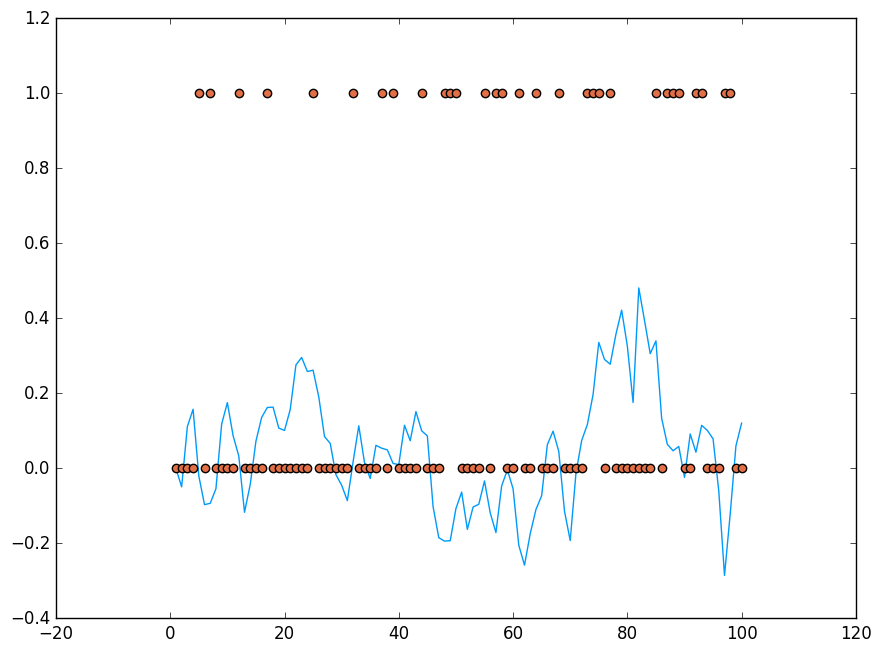

[Plots.jl] Initializing backend: pyplot


In [17]:
ar1 = AR1(0.9, 0.1)
bp = BernoulliProcess(0.35)

sim_ar = simulate(ar1, 100, 0.0)
sim_bp = simulate(bp, 100, 0)

p = plot(sim_ar, label="AR(1)")
scatter!(sim_bp, lab="Bernoulli Process")
xaxis!("T")
yaxis!("X(t)")
ylims!(-0.5, 1.5);


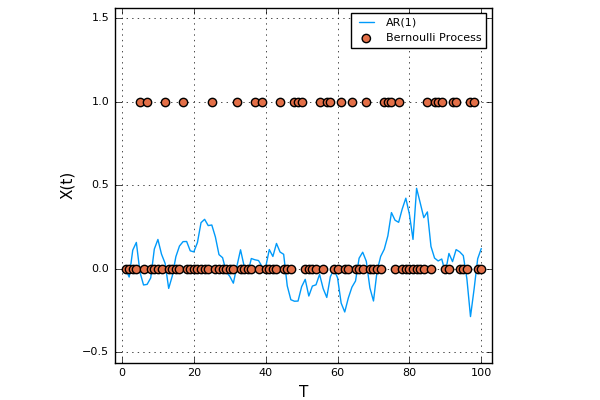

In [18]:
p

Note that even this example is a bit contrived. It is more in the spirit of helping you understand _how_ to use multiple dispatch rather than to really try to leverage its power.